# Causality Toy Example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dowhy import CausalModel

import warnings
warnings.filterwarnings('ignore')

# Set Seed for Reproducability

In [2]:
SEED = 432432
np.random.seed(SEED)

# Synthetic Data Generation

In [3]:
NUM_SAMPLES = 500

# (CONFOUNDER)
Z = np.random.normal(size=NUM_SAMPLES)

# (BINARY TREATMENT)
T = (Z + np.random.normal(size=NUM_SAMPLES) > 0).astype(int) # random increase

# (OUTCOME)
Y = 2 * T + Z + np.random.normal(size=NUM_SAMPLES)

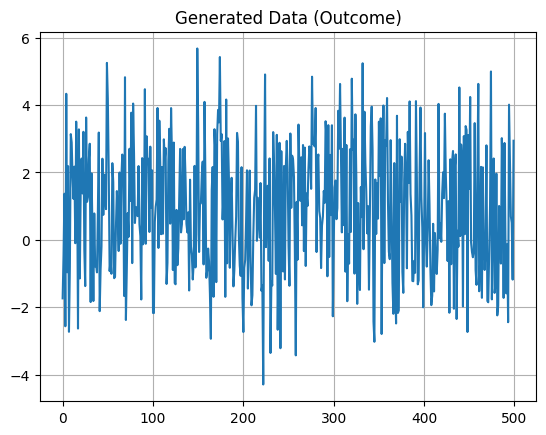

In [4]:
plt.plot(Y)
plt.title('Generated Data (Outcome)')
plt.grid('on')

# Dataframe (for DoWhy)

In [5]:
df = pd.DataFrame({'Z': Z, 'T': T, 'Y': Y})

df.head(15)

,Z,T,Y
0,-1.293202,0,-1.738818
1,-0.959488,0,-0.464332
2,0.353975,1,1.367580
3,-2.566260,0,-2.567008
4,1.899851,1,4.334389
5,-0.425996,0,-0.963848
6,0.739708,1,2.187002
7,-1.377602,0,-2.731783
8,-0.983629,0,-0.791226
9,-0.151765,1,3.136955


# Initial Assumption

Can be used for graph generation: https://dagitty.net/dags.html# 

In [6]:
# ALSO TRY:
# digraph {T -> Z; Z -> Y}
# digraph {Y -> Z; Z -> T}
# digraph {T -> Y; Z -> Y}
# digraph {T -> Y; Z -> Y; T -> Z}

initial_graph = """
digraph {Z -> T; Z -> Y; T -> Y}
"""

# Causal Model

In [7]:
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    graph=initial_graph,
)

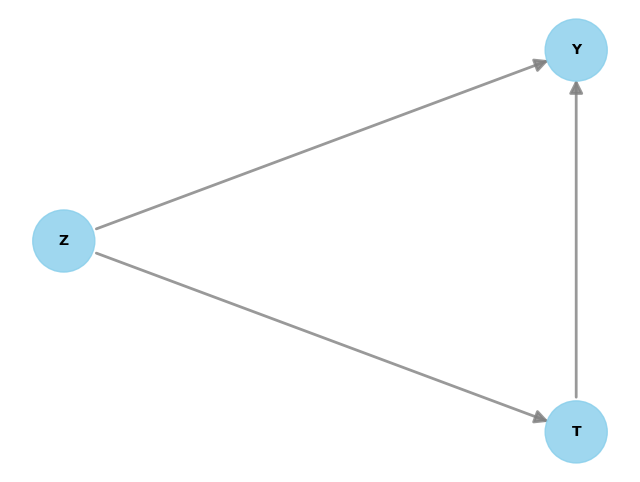

In [8]:
model.view_model()

# Identify the Effect

In [9]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,Z,U) = P(Y|T,Z)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
 d          
────(E[Y|Z])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,Z,U) = P(Y|T,Z)



# Estimate Effect

**NOTE: this uses a linear method**

In [10]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.linear_regression'
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,Z,U) = P(Y|T,Z)

## Realized estimand
b: Y~T+Z
Target units: ate

## Estimate
Mean value: 1.937912423059585



# Refute

**(These methods below are used to make sure the estimation is correct)**

**The average treatment effect (ATE):** a measure used to estimate the causal effect of a treatment or intervention on an outcome

## Random Common Cause Variable

In [11]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='random_common_cause'
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 1.937912423059585

Refute:
Refute: Add a random common cause
Estimated effect:1.937912423059585
New effect:1.9383824321848457
p value:0.96



## Unobserved Common Cause Variable

In [12]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='add_unobserved_common_cause',
    confounders_effect_on_treatment='linear', 
    confounders_effect_on_outcome='linear',
    effect_strength_on_treatment=0.01, 
    effect_strength_on_outcome=0.0
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 1.937912423059585

Refute:
Refute: Add an Unobserved Common Cause
Estimated effect:1.937912423059585
New effect:1.933716934659274



## Replacing Treatment with a Random (Placebo) Variable

In [13]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='placebo_treatment_refuter', 
    placebo_type='permute',
    num_simulations=100 # (at least 100)
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 1.937912423059585

Refute:
Refute: Use a Placebo Treatment
Estimated effect:1.937912423059585
New effect:0.0013780792917418472
p value:0.96



## Removing a Random Subset of the Data

In [14]:
refute = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='data_subset_refuter', 
    subset_fraction=0.8,
    num_simulations=100
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 1.937912423059585

Refute:
Refute: Use a subset of data
Estimated effect:1.937912423059585
New effect:1.9379285900668481
p value:0.96

